# Binary Convolutional Neural Networks

In this notebook, we first train a CNN with full precision on `CIFAR-10` data and  save the weights and biases of the trained CNN. We then use those to initialize and train the approximated version of the model : we approximate the full precision weights using a linear combination of multiple binary weight bases. 

We study the impact of an increase in binary weight bases (`num_binary_filters`) as well as an increase in the number of epochs used to train alphas (`alpha_training_epochs`), which are the coefficients of the linear combination of the binary weight bases. 

## Loading and preprocessing the data

In [1]:
%matplotlib inline

# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
from cifar_utils import load_data
from matplotlib import pyplot as plt

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train = load_data(mode='train')

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
num_training = 49000
num_validation = 1000

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data, and reshape it to be RGB size
mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image

X_train = X_train.reshape(-1,3,32,32).transpose(0,2,3,1) / 255
X_val = X_val.reshape(-1,3,32,32).transpose(0,2,3,1) / 255

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

./data/cifar-10-python.tar.gz already exists. Begin extracting...
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)


## Training the full-weights CNN

In [3]:
from approx_cnn import training
tf.reset_default_graph()
pretrained_model, best_accuracy_full_weights = training(X_train, y_train, X_val, y_val, is_binary = False,
                                                        conv_featmap = [32, 32, 64, 64, 128, 128], 
                                                        fc_units = [84, 84],
                                                        conv_kernel_size = [3, 3, 3, 3, 3, 3], 
                                                        pooling_size = [2, 2, 2, 2, 2, 2],
                                                        seed = 235,
                                                        learning_rate = 1e-2,
                                                        epoch = 20,
                                                        batch_size = 256,
                                                        verbose = True)

epoch 1 
25600/49000 loss: 1.7297626733779907, validation accuracy : 18.400000000000006%, 10.789628028869629 seconds
Best validation accuracy! iteration:100 accuracy: 18.400000000000006%
epoch 2 
2304/49000 loss: 1.3975660800933838, validation accuracy : 42.0%, 9.058035612106323 seconds
Best validation accuracy! iteration:200 accuracy: 42.0%
27904/49000 loss: 1.3565703630447388, validation accuracy : 56.3%, 8.472828149795532 seconds
Best validation accuracy! iteration:300 accuracy: 56.3%
epoch 3 
4608/49000 loss: 1.3056586980819702, validation accuracy : 58.8%, 8.911086797714233 seconds
Best validation accuracy! iteration:400 accuracy: 58.8%
30208/49000 loss: 1.0765067338943481, validation accuracy : 64.1%, 8.471027374267578 seconds
Best validation accuracy! iteration:500 accuracy: 64.1%
epoch 4 
6912/49000 loss: 1.0504623651504517, validation accuracy : 66.4%, 8.885915756225586 seconds
Best validation accuracy! iteration:600 accuracy: 66.4%
32512/49000 loss: 1.0215779542922974, valida

## Loss graph for full weight CNN model

In [4]:
# show the graph
from cnn_jupyter_tensorboard import show_graph 
tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('model/full_cnn_1544556652.meta')
    graph = tf.get_default_graph()
    show_graph(graph)

## Training the approximated CNN with different number of binary filters (epochs = 10)

In [5]:
best_accuracy_approx_weights = []
for num_binary_filters in [1, 2, 3, 4, 5, 6]:
    tf.reset_default_graph()
    print('Number of binary filters : {}'.format(num_binary_filters) + '\n')
    _, best_acc = training(X_train, y_train, X_val, y_val, is_binary = True,
                             pretrained_model = pretrained_model,
                             num_binary_filters = num_binary_filters,
                             fc_units = [84, 84],
                             pooling_size = [2, 2, 2, 2, 2, 2],
                             seed = 235,
                             learning_rate = 1e-2,
                             epoch = 10,
                             alpha_training_epochs = 10,
                             batch_size = 256,
                             verbose = False)
    best_accuracy_approx_weights.append(best_acc)  

Number of binary filters : 1

epoch 1 
Best validation accuracy! iteration:100 accuracy: 12.799999999999997%
epoch 2 
epoch 3 
Best validation accuracy! iteration:500 accuracy: 21.200000000000003%
epoch 4 
Best validation accuracy! iteration:600 accuracy: 59.9%
Best validation accuracy! iteration:700 accuracy: 68.7%
epoch 5 
Best validation accuracy! iteration:800 accuracy: 68.8%
epoch 6 
Best validation accuracy! iteration:1000 accuracy: 72.5%
epoch 7 
Best validation accuracy! iteration:1300 accuracy: 73.4%
epoch 8 
epoch 9 
epoch 10 
Training ends. The best valid accuracy is 73.4. Model named approx_cnn_1544557014.
Number of binary filters : 2

epoch 1 
Best validation accuracy! iteration:100 accuracy: 8.700000000000003%
epoch 2 
epoch 3 
Best validation accuracy! iteration:400 accuracy: 10.599999999999994%
Best validation accuracy! iteration:500 accuracy: 15.599999999999994%
epoch 4 
Best validation accuracy! iteration:600 accuracy: 58.9%
Best validation accuracy! iteration:700 acc

The accuracy clearly increases with the number of filters, with `n_binary_filters = 6` giving us only a 1.2 % boost in accuracy from the full-weights CNN. This is most likely due to the regularization effect of the binarized filters.

Text(0.5,1,'Accuracy as a function of number of binary filters')

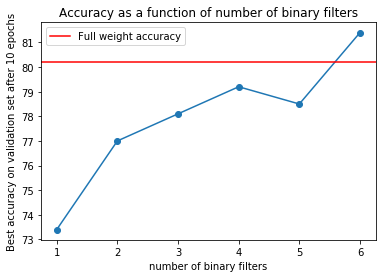

In [12]:
fig, ax = plt.subplots()
ax.scatter([1, 2, 3, 4, 5, 6], best_accuracy_approx_weights)
ax.plot([1, 2, 3, 4, 5, 6], best_accuracy_approx_weights)
ax.set_xticks([1, 2, 3, 4, 5, 6])
plt.axhline(y = best_accuracy_full_weights, color='r', linestyle='-', label = 'Full weight accuracy')
plt.xlabel('number of binary filters')
plt.ylabel('Best accuracy on validation set after 10 epochs')
plt.legend()
plt.title('Accuracy as a function of number of binary filters')

### Training the approximated CNN with different alpha_epochs 

In [8]:
best_accuracy_approx_weights_alphas = []
for alpha_training_epochs in [10, 20, 30, 40]:
    tf.reset_default_graph()
    print('Number of alpha epochs : {}'.format(alpha_training_epochs))
    _, best_acc = training(X_train, y_train, X_val, y_val, is_binary = True,
                             pretrained_model = pretrained_model,
                             num_binary_filters = 5,
                             fc_units = [84, 84],
                             pooling_size = [2, 2, 2, 2, 2, 2],
                             seed = 235,
                             learning_rate = 1e-2,
                             epoch = 10,
                             alpha_training_epochs = alpha_training_epochs,
                             batch_size = 256,
                             verbose = True)
    best_accuracy_approx_weights_alphas.append(best_acc)  

Number of alpha epochs : 10
epoch 1 
25600/49000 loss: 0.8119046688079834, validation accuracy : 9.099999999999994%, 34.93126940727234 seconds
Best validation accuracy! iteration:100 accuracy: 9.099999999999994%
epoch 2 
2304/49000 loss: 0.7908844947814941, validation accuracy : 7.700000000000003%, 33.25797939300537 seconds
27904/49000 loss: 0.8286464810371399, validation accuracy : 8.200000000000003%, 32.3710720539093 seconds
epoch 3 
4608/49000 loss: 0.7701312303543091, validation accuracy : 8.099999999999994%, 32.79551076889038 seconds
30208/49000 loss: 0.7249200940132141, validation accuracy : 8.299999999999997%, 32.303551197052 seconds
epoch 4 
6912/49000 loss: 0.6361919045448303, validation accuracy : 9.599999999999994%, 32.861358880996704 seconds
Best validation accuracy! iteration:600 accuracy: 9.599999999999994%
32512/49000 loss: 0.7105892300605774, validation accuracy : 29.700000000000003%, 32.752344369888306 seconds
Best validation accuracy! iteration:700 accuracy: 29.700000

epoch 4 
6912/49000 loss: 0.7311151027679443, validation accuracy : 61.0%, 44.25004267692566 seconds
Best validation accuracy! iteration:600 accuracy: 61.0%
32512/49000 loss: 0.7030815482139587, validation accuracy : 72.9%, 43.888375759124756 seconds
Best validation accuracy! iteration:700 accuracy: 72.9%
epoch 5 
9216/49000 loss: 0.6711310148239136, validation accuracy : 77.6%, 44.4621000289917 seconds
Best validation accuracy! iteration:800 accuracy: 77.6%
34816/49000 loss: 0.6424108743667603, validation accuracy : 77.0%, 44.14387249946594 seconds
epoch 6 
11520/49000 loss: 0.7011796832084656, validation accuracy : 75.8%, 43.84085750579834 seconds
37120/49000 loss: 0.6743634939193726, validation accuracy : 78.4%, 43.50729298591614 seconds
Best validation accuracy! iteration:1100 accuracy: 78.4%
epoch 7 
13824/49000 loss: 0.5958957076072693, validation accuracy : 73.9%, 44.547858238220215 seconds
39424/49000 loss: 0.6471011638641357, validation accuracy : 76.9%, 43.44771695137024 seco

Text(0.5,1,'Accuracy as a function of alpha epochs (5 filters)')

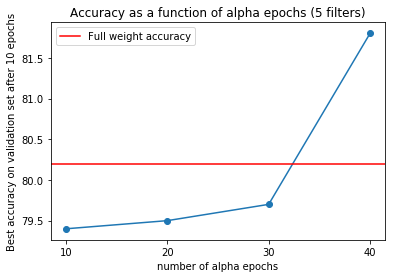

In [14]:
fig, ax = plt.subplots()
ax.scatter([10, 20, 30, 40], best_accuracy_approx_weights_alphas)
ax.plot([10, 20, 30, 40], best_accuracy_approx_weights_alphas)
ax.set_xticks([10, 20, 30, 40])
plt.axhline(y = best_accuracy_full_weights, color='r', linestyle='-', label = 'Full weight accuracy')
plt.xlabel('number of alpha epochs')
plt.ylabel('Best accuracy on validation set after 10 epochs')
plt.legend()
plt.title('Accuracy as a function of alpha epochs (5 filters)')